<span style="color:grey"> By Seongchan Kang </span>

<span style="color:grey"> Version : Python 3.10.1 in Window </span>

# Text Summarize 실습

아마존 리뷰 데이터를 통해 긴 텍스트를 문장에서 요약하는 딥러닝 모델을 만들기

트랜스포머(어택션)를 활용하여 적용

데이터는 캐글에서 가져옴 (URL : <span> https://www.kaggle.com/snap/amazon-fine-food-reviews </span>)

그외 참고 사이트
 - <span> https://wikidocs.net/24996 </span>
 - <span> https://settlelib.tistory.com/56 </span>
 - <span> https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646 </span>
 - <span> https://glee1228.tistory.com/3 </span>


# 대략적인 과정

1. 텍스트 데이터 가져오기

2. 텍스트 데이터 전처리  

3. 딥러닝 모델 설계

4. 어택션 메커니즘 적용

5. 평가 및 적용

# Seq2Seq 와 어택션 메커니즘

기존 seq2seq은 디코더를 고정된 사이즈의 Context Vector로 받아 인코더로 변환하는 것

하지만 이 모델의 단점은 사이즈가 커지면 모든 정보를 담지 못한다는 것이 있음

어택션 메커니즘은 이 모델의 한계를 해결하기 위한 방안

그래서 어택션 메커니즘에 대해 간단히 말하면 각각의 입력되는 데이터에 가중치를 더하는 방법

집중해야할 단어에 대한 메커니즘에 대한 설계가 가능해짐

이런 전체적인 메커니즘을 가능하게 하기 위해 값이 잘못된 방향을 가고 있을 때 다시 정답으로 넣어 주는 과정이 필요 (Teacher Forcing이라고 함)

이것(Teacher Forcing)이 모델의 학습과 효율을 향상 시킴


## 데이터 가져오기

모든 데이터를 한번에 학습시키고 모델링하면 시간이 오랙 걸림

그래서 1000개의 데이터만 우선 뽑아서 실습

변수 설명
- 'Id' : 단순 넘버링을 위한 값
- 'ProductId' : 아마존에서 파는 제품의 번호
- 'UserId' : 암호화된 유저 아이디
- 'ProfileName' : 유저의 닉네임
- 'HelpfulnessNumerator' : 리뷰를 본 사람들 중에 이 리뷰가 유용하다고 한 사람의 수
- 'HelpfulnessDenominator' : 리뷰를 본 전체 사람의 수
- 'Score' : 리뷰어가 남긴 점수
- 'Time' : 리뷰어가 리뷰를 작성한 시점의 시간(Unix timestamp)(https://www.daleseo.com/python-time/)
- 'Summary' : "Text"변수를 요약한 것
- 'Text' : Reriews 본문

In [1]:
# 기본 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
review_df = pd.read_csv("Reviews.csv", nrows = 1000)
review_df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
995,996,B006F2NYI2,A1D3F6UI1RTXO0,Swopes,1,1,5,1331856000,Hot & Flavorful,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...
996,997,B006F2NYI2,AF50D40Y85TV3,Mike A.,1,1,5,1328140800,Great Hot Sauce and people who run it!,"Man what can i say, this salsa is the bomb!! i..."
997,998,B006F2NYI2,A3G313KLWDG3PW,kefka82,1,1,5,1324252800,this sauce is the shiznit,this sauce is so good with just about anything...
998,999,B006F2NYI2,A3NIDDT7E7JIFW,V. B. Brookshaw,1,2,1,1336089600,Not Hot,Not hot at all. Like the other low star review...


In [3]:
review_df = review_df[['Text','Summary']]
review_df

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy
...,...,...
995,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...,Hot & Flavorful
996,"Man what can i say, this salsa is the bomb!! i...",Great Hot Sauce and people who run it!
997,this sauce is so good with just about anything...,this sauce is the shiznit
998,Not hot at all. Like the other low star review...,Not Hot


## 텍스트 데이터 전처리

### 중복된 데이터 처리

In [4]:
# 중복 확인
review_df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Length: 1000, dtype: bool

In [5]:
# Text와 Summary 두 칼럼에서 중복되는 행중에 첫번째만 남겨두고 삭제
review_df = review_df.drop_duplicates(keep = 'first')
review_df

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy
...,...,...
995,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...,Hot & Flavorful
996,"Man what can i say, this salsa is the bomb!! i...",Great Hot Sauce and people who run it!
997,this sauce is so good with just about anything...,this sauce is the shiznit
998,Not hot at all. Like the other low star review...,Not Hot


In [6]:
# 인덱스를 다시 정렬
review_df = review_df.reset_index(drop = True)
review_df

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy
...,...,...
992,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...,Hot & Flavorful
993,"Man what can i say, this salsa is the bomb!! i...",Great Hot Sauce and people who run it!
994,this sauce is so good with just about anything...,this sauce is the shiznit
995,Not hot at all. Like the other low star review...,Not Hot


### 결측치 데이터 처리

In [7]:
# 결측치 확인
review_df.isnull().sum()

Text       0
Summary    0
dtype: int64

In [8]:
# 결측치 제거
review_df = review_df.dropna()
review_df

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy
...,...,...
992,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...,Hot & Flavorful
993,"Man what can i say, this salsa is the bomb!! i...",Great Hot Sauce and people who run it!
994,this sauce is so good with just about anything...,this sauce is the shiznit
995,Not hot at all. Like the other low star review...,Not Hot


In [9]:
# 결측치 재확인
review_df.isnull().sum()

Text       0
Summary    0
dtype: int64

### 정제 및 정규화

1. 정제(cleaning): 불필요한 단어 또는 문자를 제거
2. 정규화(normalization): 같은 의미이면서 표현이 다른 단어를 통합
 - 규칙기반 정규화를 시키기엔 너무 많음 
 - 아래 참고 URL에 영어 규칙기반 정규화를 위한 딕셔너리가 있음
 - 참고 URL : <span> https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646 </span>

In [10]:
# 필요시 주석 지우고 다운로드
#%pip install nltk
#%pip install bs4
#%pip install autocorrect
#%pip install lxml

In [11]:
# 라이브러리 설치 및 불러오기
from nltk.corpus import stopwords 
from bs4 import BeautifulSoup 
from autocorrect import Speller

import nltk
import re

In [12]:
# 불용어 
nltk.download('stopwords')
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\clown\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\clown\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
# 다운로드한 NLTK의 불용어
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))

불용어 개수 : 179


In [14]:
# 위에 있는 URL에서 가져옴
# 정규화를 위한 규칙 #
contractions_dict = {
  "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
  "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
  "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", 
  "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", 
  "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
  "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
  "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
  "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
  "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
  "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
  "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
  "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", 
  "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
  "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", 
  "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
  "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
  "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
  "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
  "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", 
  "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", 
  "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", 
  "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
  "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", 
  "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", 
  "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", 
  "you've": "you have"
  }

## 키값 가져오기
contractions_re = re.compile('(%s)'%'|'.join(contractions_dict.keys()))
contractions_re # 확인용 1

re.compile(r"(ain't|aren't|can't|'cause|could've|couldn't|didn't|doesn't|don't|hadn't|hasn't|haven't|he'd|he'll|he's|how'd|how'd'y|how'll|how's|I'd|I'd've|I'll|I'll've|I'm|I've|i'd|i'd've|i'll|i'll've|i'm|i've|isn't|it'd|it'd've|it'll|it'll've|it's|let's|ma'am|mayn't|might've|mightn't|mightn't've|must've|mustn't|mustn't've|needn't|needn't've|o'clock|oughtn't|oughtn't've|shan't|sha'n't|shan't've|she'd|she'd've|she'll|she'll've|she's|should've|shouldn't|shouldn't've|so've|so's|this's|that'd|that'd've|that's|there'd|there'd've|there's|here's|they'd|they'd've|they'll|they'll've|they're|they've|to've|wasn't|we'd|we'd've|we'll|we'll've|we're|we've|weren't|what'll|what'll've|what're|what's|what've|when's|when've|where'd|where's|where've|who'll|who'll've|who's|who've|why's|why've|will've|won't|won't've|would've|wouldn't|wouldn't've|y'all|y'all'd|y'all'd've|y'all're|y'all've|you'd|you'd've|you'll|you'll've|you're|you've)",
           re.UNICODE)

In [15]:
# 확인용 2
document = "Hey, we aren't employees and we can't regist."

document = ' '.join([contractions_dict[t] if t in contractions_dict else t for t in document.split(" ")])

document

'Hey, we are not employees and we cannot regist.'

In [16]:
# 그냥 추가적으로 함수를 이용한 방법이라고 알고 있기

# 스테밍의 방법중 하나
from nltk.stem import SnowballStemmer

## 정규화를 위한 함수 ##
## 함수로 만들어서 사용하는게 오히려 하는데 시간이 오래걸림
def expand_contractions(s, contractions_dict = contractions_dict) :
    def replace(match) :
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

## 토큰화 후 구두점 없애기 위한 함수 ##
## 구두점은 단순히 함부로 없애기엔 한계가 있기에 적절히 상화에 맞춰서 사용
def remove_punct(token):
    return [word for word in token if word.isalpha()]

In [17]:
# 위의 함수와 달리 이번 실습에서 직접 사용하는 코드 #
## 스펠링 맞춤법 ##
# https://www.delftstack.com/ko/howto/python/python-spell-checker/
spell = Speller(lang = "en")


# 전체 전처리 함수 #
## re.sub（검색 패턴, 치환되는 텍스트, 치환할려는 텍스트）
def preprocess_doc(document, remove_stopwords = True) :
    ## 소문자로 변환
    document = document.lower()

    ## 괄호 없애기
    document = BeautifulSoup(document, "lxml").text  # html 태그 제거 (<> ~~ <> 같은)
    document = re.sub(r'\([^)]*\)', ' ', document)   # 괄호로 묶인 문자열 제거 

    ## 정규화
    ## 띄어쓰기로 구분한 문장을 규칙 안에 있는거면 정규화 아니면 다시 똑같이 내보내기
    ## 딕셔너리로 되어있기 때문에 가능
    document = ' '.join([contractions_dict[t] if t in contractions_dict else t for t in document.split(" ")])   # 규칙기반 정규화    

    ## 필요없는 내용 제거 (스테밍)
    document = re.sub(r"'s\b","",document)           # 소유격 제거
    document = re.sub('"','', document)              # 큰따옴표 제거
    document = re.sub("'",'', document)              # 작은따옴표 제거
    document = re.sub("[^a-zA-Z]", " ", document)    # 영어 외 문자 공백치환

    ## 그외 전처리
    document = spell(document)                       # 철자 수정

    ## 불용어 처리 
    ## '구분자'.join(리스트)
    ## 문장을 구분하고 구분한 단어게 불용어가 아니고 공백이 아니면 join 불용어면 버리기
    if remove_stopwords :                            # 불용어 제거 (Text)
        tokens = ' '.join(word for word in document.split() if not word in stop_words if len(word) > 1)     
    ## Summary에서 불용어 처리를 하지않는 이유는 요약 방법이 "추상적 요약"이기 때문에 자연스러운 요약이 중요
    else :                                           # 불용어 미제거 (Summary)
        tokens = ' '.join(word for word in document.split() if len(word) > 1)
    return tokens

In [18]:
# Text 전처리 실행 #
all_text = []

## 텍스트 한문장씩 뽑아서 전처리후 all_text로 넣기
for s in review_df['Text']:
    all_text.append(preprocess_doc(s))

all_text[:5]
# 함수를 사용해서 처리했을 경우 약 1000개의 데이터는 4분 30초 정도 걸림
# 하지만 한줄로 코드를 만들어서 처리한 경우 같은 데이터의 갯수도 약 2분 30초정도 걸림

c:\Users\clown\.conda\envs\tf_test\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unwanted sure error vendor intended represent product jumbo',
 'connection around centuries light pillow citrus relation nuts case filters cut tiny squares liberally coated powdered sugar tiny youthful heaven chew flavorful highly recommend dummy treat familiar story lewis lion witch wardrobe treat seduces demand selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great staff great price wide assortment dummy staff delivery quick staff lover deal']

In [19]:
# Summary 모음
all_summary = []

for s in review_df['Summary']:
    all_summary.append(preprocess_doc(s, 0))
    
all_summary[:5]

# 이건 약 15초

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great staff']

In [20]:
# 다시 저장
review_df['Text'] = all_text
review_df['Summary'] = all_summary
review_df

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,connection around centuries light pillow citru...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great staff great price wide assortment dummy ...,great staff
...,...,...
992,black market hot sauce wonderful husband loves...,hot flavorful
993,man say salsa bomb different kinds almost ever...,great hot sauce and people who run it
994,sauce good anything like adding asian food any...,this sauce is the shiznit
995,hot like low star reviewer got suffered seeing...,not hot


In [21]:
review_df.isnull().sum()

Text       0
Summary    0
dtype: int64

### 이상치 처리

In [22]:
# 길이 분포 출력 # 
## 문장 뽑아 구분한 뒤 길이만 출력하여 리스트로 저장
t_len = [len(t.split()) for t in review_df['Text']]
s_len = [len(s.split()) for s in review_df['Summary']]

print('Text 최소 길이 : {}'.format(np.min(t_len)))
print('Text 최대 길이 : {}'.format(np.max(t_len)))
print('Text 평균 길이 : {}'.format(np.mean(t_len)))
print('Summary 최소 길이 : {}'.format(np.min(s_len)))
print('Summary 최대 길이 : {}'.format(np.max(s_len)))
print('Summary 평균 길이 : {}'.format(np.mean(s_len)))

Text 최소 길이 : 5
Text 최대 길이 : 350
Text 평균 길이 : 34.72818455366098
Summary 최소 길이 : 0
Summary 최대 길이 : 22
Summary 평균 길이 : 3.95987963891675


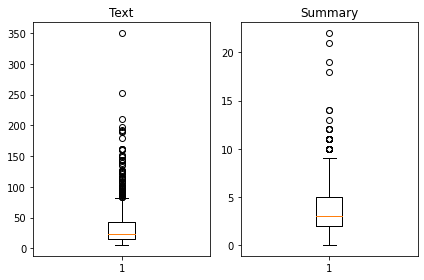

In [23]:
# Text boxplot
plt.subplot(1, 2, 1)
plt.boxplot(t_len)
plt.title('Text')

# Summary boxplot
plt.subplot(1, 2, 2)
plt.boxplot(s_len)
plt.title('Summary')

plt.tight_layout()
plt.show()

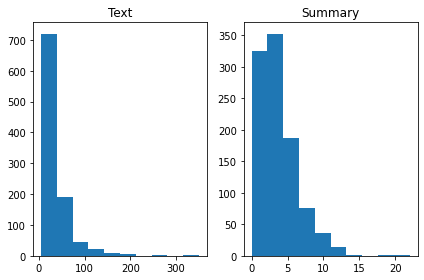

처리하기 전 데이터수 : 997


In [24]:
# Text를 한눈에 확인이 어려워서 다시 hist로 확인
# 보는김에 Summary도 같이 확인
plt.subplot(1, 2, 1)
plt.hist(t_len)
plt.title('Text')

plt.subplot(1, 2, 2)
plt.hist(s_len)
plt.title('Summary')

plt.tight_layout()
plt.show()

print('처리하기 전 데이터수 :',(len(review_df)))

In [25]:
# Boxplot 기준으로 이상치 제거 #

# Text #
review_df = review_df[review_df['Text'].apply(lambda x: len(x.split()) <= 100)]  # 100(최댓값에 근접한 숫자)을 기준으로 자르기
review_df = review_df[review_df['Text'].apply(lambda x: len(x.split()) >= 5)]    # 5(텍스트 최소값)을 기준으로 자르기

# Summary # 
review_df = review_df[review_df['Summary'].apply(lambda x: len(x.split()) <= 10)] # 10(최댓값에 근접한 숫자)을 기준으로 자르기
review_df = review_df[review_df['Summary'].apply(lambda x: len(x.split()) >= 1)]  # 1(서머리 0을 미리 제거함)을 기준으로 자르기

# 인덱스 다시 처리 후 확인 #
review_df = review_df.reset_index(drop = True)
review_df

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,connection around centuries light pillow citru...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great staff great price wide assortment dummy ...,great staff
...,...,...
933,black market hot sauce wonderful husband loves...,hot flavorful
934,man say salsa bomb different kinds almost ever...,great hot sauce and people who run it
935,sauce good anything like adding asian food any...,this sauce is the shiznit
936,hot like low star reviewer got suffered seeing...,not hot


## 토큰화를 위한 작업

In [26]:
#%pip install tensorflow

In [27]:
# 토큰화를 위한 라이브러리 불러오기
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [32]:
# 데이터 타입 확인
review_df.dtypes

# 변환이 필요할 경우 #
# 데이터 타입 str으로 변환
#review_df = review_df.astype('str')
#review_df.dtypes

Text              object
Summary           object
decoder_input     object
decoder_target    object
dtype: object

In [30]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
# seq2seq 모델은 들어가는 <Start>와 끝나는 <End>가 그래서 앞 뒤로 문장을 넣음 
review_df['decoder_input'] = review_df['Summary'].apply(lambda x : 'start '+ x)
review_df['decoder_target'] = review_df['Summary'].apply(lambda x : x + ' end')
review_df

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,start good quality dog food,good quality dog food end
1,product arrived labeled jumbo salted peanuts p...,not as advertised,start not as advertised,not as advertised end
2,connection around centuries light pillow citru...,delight says it all,start delight says it all,delight says it all end
3,looking secret ingredient robitussin believe f...,cough medicine,start cough medicine,cough medicine end
4,great staff great price wide assortment dummy ...,great staff,start great staff,great staff end
...,...,...,...,...
933,black market hot sauce wonderful husband loves...,hot flavorful,start hot flavorful,hot flavorful end
934,man say salsa bomb different kinds almost ever...,great hot sauce and people who run it,start great hot sauce and people who run it,great hot sauce and people who run it end
935,sauce good anything like adding asian food any...,this sauce is the shiznit,start this sauce is the shiznit,this sauce is the shiznit end
936,hot like low star reviewer got suffered seeing...,not hot,start not hot,not hot end


In [31]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 저장
encoder_input = np.array(review_df['Text'])
decoder_input = np.array(review_df['decoder_input'])
decoder_target = np.array(review_df['decoder_target'])

In [34]:
# 순서(정수 시퀀스) 만들기
int_ar = np.arange(encoder_input.shape[0])

# 셔플
np.random.shuffle(int_ar)

print(int_ar)

[261 263 719 525 374 933 757 449 519 618 430 865 876 555 524 805 871  75
 434 471 321  36 276 401 925 548 680 568 517 341 363  31 469 746 608 160
  63 339 825 265 236 666 801 349 785 467 382 761 522 658 597 527  20 863
 282 347 421 461 320 250 436 411 376 395 809 924 489   0  85 745 613 251
 664 661   4 445 814 379 107 743 912  80 698 180 468 290 540 126 632 113
 847 409 356 141 404 570 815 612 841 292  27 148 293 759 718 513 234 751
 514 386 122 798 362  45 503 536 736 619 707  93 103 296 572 134 869  98
 106 696 581  77 455 554 796 278 167 171 903 238 375 766  59 114 653 579
 419  69 771 175 334 491 723 646  96  35 804 688 286 690 170 350 119 738
 774 705 587 537 402 727 911 262 360 459 770 717 920  26 722 385 852 391
 671 880 826  87 714 417 729  15 588  49 204 441 418 665  76 304 381 110
 245 302 583 227 748 294  13 200 348 830 152 864 388 630 685 634 202 217
 610 934 179 143 614 195 424 151 730 444 460 387 767 222 567 819 735 644
 443 625 874 515 853 626 832 112 559  74 611 806 65

In [35]:
# 샘플 순서(정수 시퀀스)대로 정의
encoder_input = encoder_input[int_ar]
decoder_input = decoder_input[int_ar]
decoder_target = decoder_target[int_ar]

In [36]:
# 테스트 데이터 수 20% 확인
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 187


In [37]:
# 데이터 분할 #
# 학습 데이터 수 80% 로 할당
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

# 테스트 데이터 수 20% 로 할당
encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

# 확인용
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 751
훈련 레이블의 개수 : 751
테스트 데이터의 개수 : 187
테스트 레이블의 개수 : 187


## 토큰화

### 텍스트 데이터 단어 집합 만들기 및 토큰화

- 빈도 분석을 위한 토큰화
- 빈도 분석
- 위 결과를 바탕으로 다시 토큰화 진행

In [38]:
# 단어 빈도 확인 및 단어 집합 만들기

# 함수 선언
src_tokenizer = Tokenizer()

# 텍스트 데이터로 단어집합 만들기
src_tokenizer.fit_on_texts(encoder_input_train)  # 문자 데이터를 입력받아서 토큰화된 리스트의 형태로 변환

In [49]:
# 등장 빈도수가 n회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 2                               # 확인할 단어의 수
total_cnt = len(src_tokenizer.word_index)   # 총 단어의 수
rare_cnt = 0                                # 빈도수가 threshold보다 작은 단어의 수
total_freq = 0                              # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0                               # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

# 원래는 비율을 확인하여 토큰화 과정에서 제거하고 토큰화를 하지만 제거하긴에 1000개의 데이터에선 적은 빈도의 단어를 제거하기 힘들어 보임
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수 : %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 3961
등장 빈도가 1번 이하인 희귀 단어의 수 : 1839
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : 2122
단어 집합에서 희귀 단어의 비율: 46.42766978035849
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.312991592080282


In [50]:
# n회 미만인 단어들은 정수 인코딩 과정에서 배제
# 적은 빈도의 단어를 제거 후 하는 과정이라면 아래 주석처리된 토큰화를 진행
#src_vocab = total_cnt - rare_cnt  # 단어집합 크기
#src_tokenizer = Tokenizer(num_words = src_vocab)  # 단어 빈도가 많은 순서로 num_words개의 단어를 보존

# 제거없이 토큰화
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)   # 문자 데이터를 입력받아서 리스트의 형태로 변환 # 키-값 형태

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

### 서머리 데이터 단어 집합 만들기 및 토큰화

- 빈도 분석을 위한 토큰화
- 빈도 분석
- 위 결과를 바탕으로 다시 토큰화 진행

In [51]:
# 디코드 인풋
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [53]:
# 등장 빈도수가 n회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 2                              # 확인할 단어의 수
total_cnt = len(tar_tokenizer.word_index)  # 단어의 수
rare_cnt = 0                               # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0                             # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0                              # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

# 서머리도 원래는 비율을 확인하여 토큰화 과정에서 제거하고 토큰화를 하지만 제거하긴에 1000개의 데이터에선 적은 빈도의 단어를 제거하기 힘들어 보임
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수 : %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율 :", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 853
등장 빈도가 1번 이하인 희귀 단어의 수 : 536
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : 317
단어 집합에서 희귀 단어의 비율 : 62.83704572098476
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 15.248933143669985


In [54]:
# n회 미만인 단어들은 정수 인코딩 과정에서 배제
# 적은 빈도의 단어를 제거 후 하는 과정이라면 아래 주석처리된 토큰화를 진행
#tar_vocab = total_cnt - rare_cnt
#tar_tokenizer = Tokenizer(num_words = tar_vocab)  # 단어 빈도가 많은 순서로 num_words개의 단어를 보존

#제거 없이 토큰화
tar_tokenizer = Tokenizer()

# 토큰화
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 학습 데이터 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)

# 테스트 데이터 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

### 데이터 처리

모델을 시작(start)과 끝(end)을 나타내는 추가된 단어 때문에 문장의 인덱스 길이가 1이 됨. 이를 제거.

In [55]:
# 길이가 1인 데이터를 따로 저장
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

# 확인용
print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 5


In [56]:
# 결측지 제거
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

# 확인용
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 751
훈련 레이블의 개수 : 751
테스트 데이터의 개수 : 182
테스트 레이블의 개수 : 182


c:\Users\clown\.conda\envs\tf_test\lib\site-packages\numpy\lib\function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


## 패딩

병렬 연산을 위해서 여러 문장의 길이를 임의로 동일하게 맞춰주는 작업

In [57]:
# 이 길이는 boxplot 이상치 확인 부분에서 정했던 길이
text_max_len = 100
summary_max_len = 10

# 패딩
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')

decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

## 모델링 및 훈련

- 어텐션 메커니즘 : 손실되는 RNN의 은닉상태의 정보들을위해, 모든 은닉 상태들을 다시 한 번 참고하기위해 사용

In [58]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Bidirectional, Dropout, AdditiveAttention
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras import optimizers
import os

In [59]:
# 입력층과 임베딩 층 설정
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,)) # 위에 설정

# 인코더의 임베딩 층
enc_emb = Embedding(3961, embedding_dim)(encoder_inputs) # 128차원으로 임베딩 # 3961은 위에 토큰화과정에서 나온 단어 집합의 크기

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
## 두번째 층 위로 쌓을 예정 그래서 리터 시퀀스가 True
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [60]:
# 디코더 설정 #
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(853, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [61]:
# 디코더의 출력층
decoder_softmax_layer = Dense(3961, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 128)     507008      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [67]:
from Attention import AttentionLayer

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(3961, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 128)     507008      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [68]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [71]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)

history = model.fit(
    x = [encoder_input_train, decoder_input_train], 
    y = decoder_target_train, 
    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test), 
    batch_size = 8, callbacks=[es], epochs = 50)

Epoch 1/50
94/94 [==============================] - 841s 9s/step - loss: 3.0571 - val_loss: 1.9194
Epoch 2/50
94/94 [==============================] - 843s 9s/step - loss: 2.4058 - val_loss: 1.8514
Epoch 3/50
94/94 [==============================] - 847s 9s/step - loss: 2.2912 - val_loss: 1.8382
Epoch 4/50
94/94 [==============================] - 678s 7s/step - loss: 2.2237 - val_loss: 1.8554
Epoch 5/50
94/94 [==============================] - 328s 3s/step - loss: 2.1761 - val_loss: 1.8689
Epoch 00005: early stopping


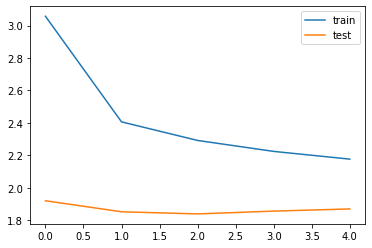

In [72]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()